In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model


ModuleNotFoundError: No module named 'tensorflow.python'

In [2]:
# Load the data
data = pd.read_csv("Epileptic Seizure Recognition.csv")

# Drop the first column (Unnamed)
data = data.drop(columns=['Unnamed'])

# Separate features (X) and labels (y)
X = data.iloc[:, :-1].values  # Features are all columns except the last one
y = data.iloc[:, -1].values   # The last column is the target

# Convert seizure labels to binary (0: No seizure, 1: Seizure)
y[y > 1] = 0


In [3]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
# Reshape data for CNN
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [5]:
# Create the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer (optional)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))


In [6]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_CNN_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model
model.fit(X_train_scaled, y_train, epochs=150, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7596 - loss: 0.4779 - val_accuracy: 0.9543 - val_loss: 0.1210
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9550 - loss: 0.1130 - val_accuracy: 0.9647 - val_loss: 0.0928
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9621 - loss: 0.0885 - val_accuracy: 0.9630 - val_loss: 0.0814
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9686 - loss: 0.0755 - val_accuracy: 0.9728 - val_loss: 0.0761
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9803 - loss: 0.0583 - val_accuracy: 0.9734 - val_loss: 0.0654
Epoch 6/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9818 - loss: 0.0489 - val_accuracy: 0.9761 - val_loss: 0.0657
Epoch 7/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9841 - loss: 0.0474 - val_accuracy: 0.9799 - val_loss: 0.0598
Epoch 8/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9888 - loss: 0.0324 - val_accuracy: 0.

In [7]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy * 100, "%")
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Print additional metrics (optional)
predictions = model.predict(X_test_scaled)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9748 - loss: 0.0698
Loss: 0.058882102370262146
Accuracy: 97.86956310272217 %
Test Loss: 0.0589, Test Accuracy: 0.9787
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1802
           1       0.97      0.93      0.95       498

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.97      2300
weighted avg       0.98      0.98      0.98      2300

[[1786   16]
 [  33  465]]


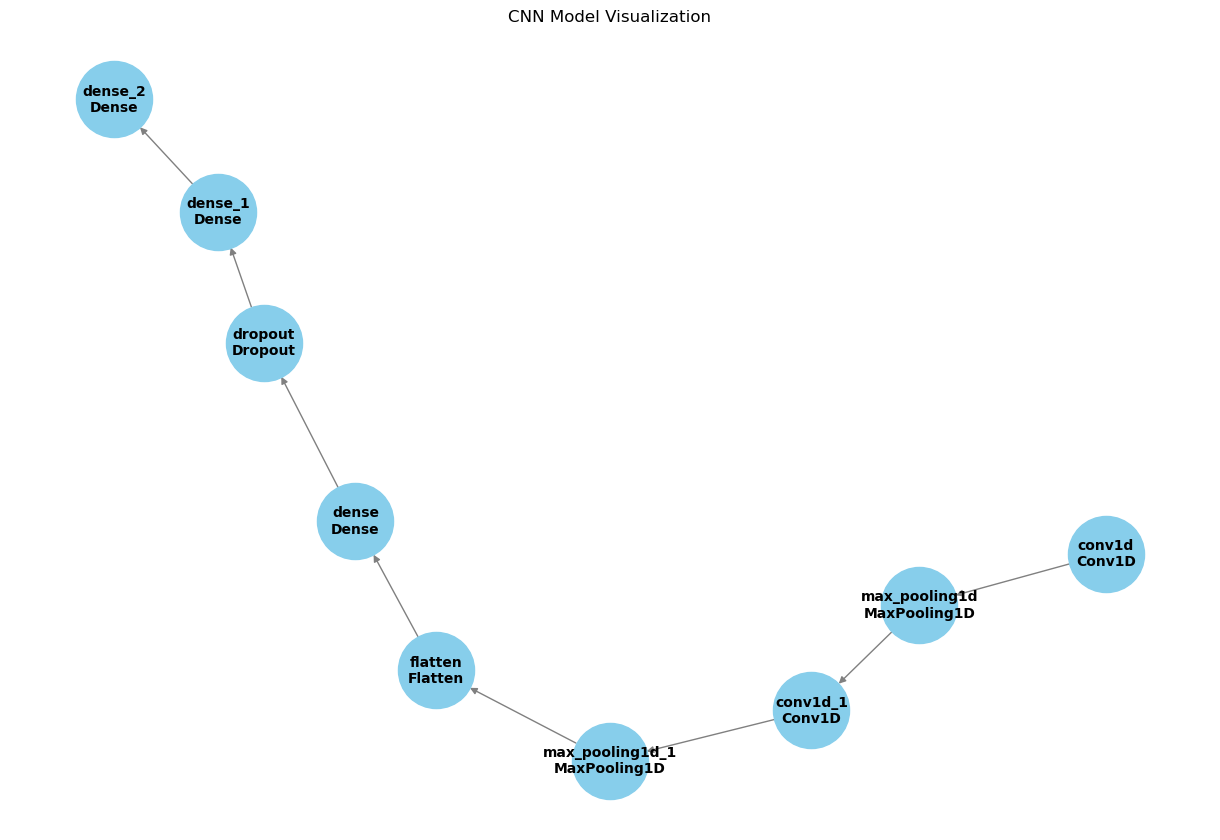

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_model(model, file_name="cnn_model.png"):
    G = nx.DiGraph()

    # Add nodes with layer names and types
    for i, layer in enumerate(model.layers):
        G.add_node(i, label=f"{layer.name}\n{layer.__class__.__name__}")
    
    # Add edges between layers
    for i in range(len(model.layers) - 1):
        G.add_edge(i, i + 1)
    
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', font_color='black', edge_color='gray')
    
    # Add the title
    plt.title("CNN Model Visualization")
    
    # Save the visualization as a PNG file
    plt.savefig(file_name, format="png")
    
    # Optionally show the plot
    plt.show()

# Call the function to visualize and save the model
visualize_model(model, file_name="cnn_model.png")
